# <u> Part 1: Pair Identification

## Install Package

In [1]:
!pip install kneed
from kneed import KneeLocator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE

from statsmodels.tsa.stattools import coint

from itertools import cycle

import scipy.cluster.hierarchy as shc

## Data Importing & Cleaning

In [2]:
stockdata = pd.read_excel('commod_data.xlsx')

In [3]:
stockdata["Date"] = pd.to_datetime(stockdata['Date'], format="%Y-%m-%d")

In [4]:
stockdata = stockdata.loc[(stockdata["Date"] >= '2009-01-01')
                     & (stockdata["Date"] < '2017-12-31')]

In [5]:
# Data Import
stockdata = stockdata.iloc[: , 1:].pct_change()
stockdata = stockdata.iloc[1: , :]
stockdata

,CRUDOIL,GOLDBLN,LCPCASH,EIAEBRT,OILBREN,WHEATSF,LAHCASH,LNICASH,CORNUS2,SILVERH,...,FUELOIL,NATBGAS,EEXPEAK,DAPNOCB,WSUGDLY,WOLAWCE,WSUGDLY.1,PAOLMAL,USTEERS,MILKGDA
110,0.039013,0.017571,0.051862,0.198772,0.070640,0.000000,0.020395,0.129296,0.013228,0.043557,...,0.044256,-0.056589,0.506681,0.000000,0.000000,0.012192,0.074171,0.046296,0.007300,0.000000
111,0.053302,-0.031116,-0.015471,0.067536,0.144588,0.000000,-0.014625,-0.027307,-0.005222,-0.088696,...,0.053368,0.039607,-0.083266,0.007692,0.000000,0.013887,0.001625,0.035398,0.004325,-0.023529
112,-0.004712,-0.005353,0.064444,0.066536,0.065301,0.053279,0.036609,0.031760,0.044619,0.069656,...,0.047943,0.065718,-0.055613,0.000000,0.000000,-0.001468,0.034063,0.008547,0.000000,0.000000
113,-0.122478,0.001478,-0.013794,-0.054408,-0.051786,-0.062257,-0.008272,-0.071749,-0.035176,0.000000,...,-0.081917,0.000146,0.428361,0.000000,0.000000,0.001750,-0.021961,0.000000,0.000000,0.000000
114,-0.021816,0.013050,-0.043925,-0.071166,-0.014044,-0.012448,-0.024543,-0.061492,-0.020833,-0.011597,...,0.020202,-0.037055,0.189397,0.000000,0.009772,-0.007894,0.000000,-0.033898,-0.009311,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.600575,0.000000,0.000000,0.000000,0.000000,0.000000,0.002172,0.000000
2452,0.031831,0.006451,0.000000,0.000000,0.000000,-0.006993,0.000000,0.000000,0.006211,0.007313,...,0.039121,-0.000037,-1.693773,0.000000,0.000000,0.000130,0.000000,0.000000,0.000000,-0.022556
2453,-0.005503,0.002784,0.016549,0.021978,0.023267,0.016432,0.027736,-0.001988,0.003086,0.009679,...,-0.003167,-0.030610,-4.648456,0.000000,0.000000,0.005959,0.019890,0.024793,0.000000,0.015385
2454,0.003353,0.006228,0.007151,0.011661,0.004066,0.000000,0.014609,0.020459,-0.006154,0.008987,...,0.010966,0.027541,-0.121665,0.000000,-0.002222,0.003413,0.004035,0.008065,0.000000,0.015152


In [6]:
# Data Preparation
returns = stockdata.mean()*259
returns = pd.DataFrame(returns)
returns.columns = ['returns']
returns['volatility'] = stockdata.std()*np.sqrt(259)

# Normalization
scale = StandardScaler().fit(returns)
scaled_data = pd.DataFrame(scale.fit_transform(returns),columns = returns.columns, index = returns.index)
X = scaled_data

In [7]:
X.sort_values(by='returns', ascending=False)

,returns,volatility
ELEPJMP,5.388525,3.249884
ELEPJMB,4.916699,3.659100
EEXBASE,1.948366,4.903566
EEXPEAK,1.637127,3.288423
PALLADM,-0.159496,-0.260735
...,...,...
SOYBEAN,-0.270700,-0.303641
PLATFRE,-0.270785,-0.329465
COCINUS,-0.284667,-0.297261
MILKGDA,-0.286840,-0.337971


## Pair Selection

### K-Means Clustering

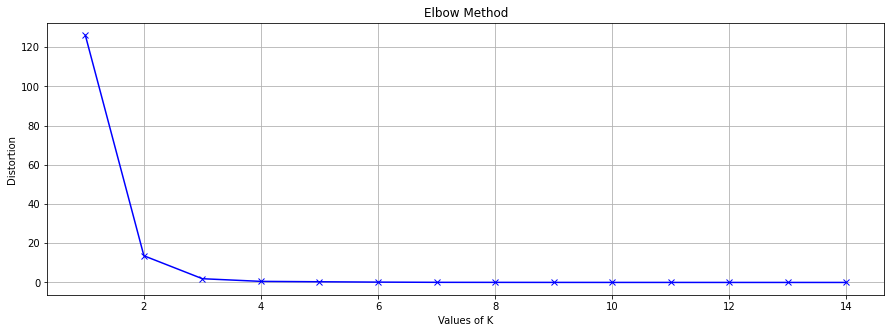

Suggested number of clusters:  3


In [8]:
# Optimize K - Distortion Method
K = range(1,15)
distortions = []

# Fit Model
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

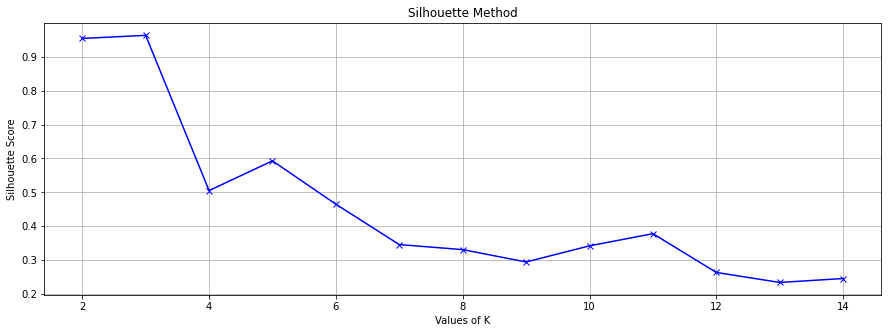

Suggested number of clusters:  4


In [9]:
# Optimize K - Silhouettes Method
K = range(2,15)
silhouettes = []

# Fit Model
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

# Plot
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', 4)

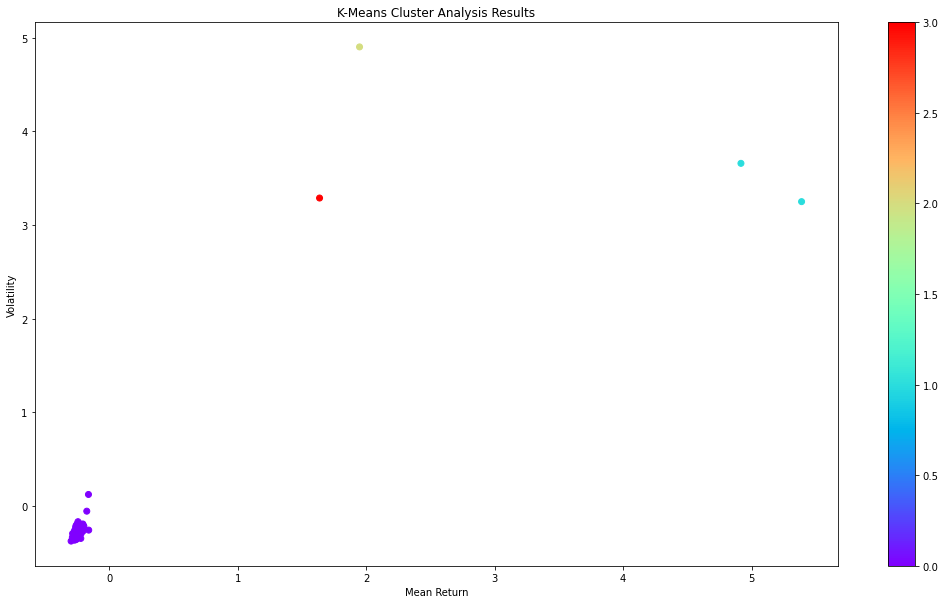

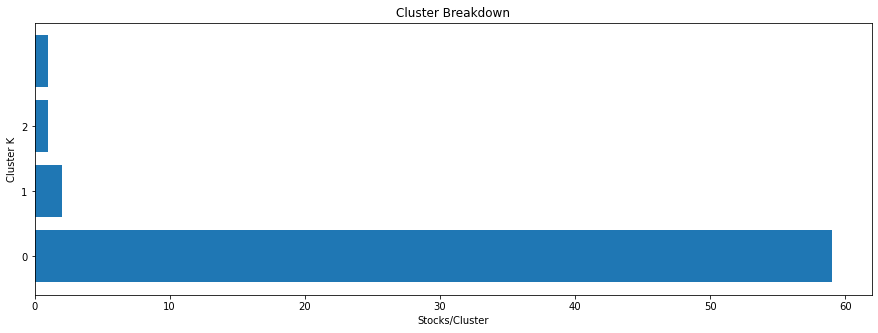

In [10]:
# Optimal K Cluster = 4
c = 4

# Fit Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
labels = k_means.predict(X)

# Plot
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=labels, cmap="rainbow", label = X.index)
ax.set_title('K-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Plot
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
fig = plt.figure(figsize= (15,5))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Breakdown')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster K')
y = [0,1,2]
plt.yticks(y)
plt.show()

### Hierarchical Clustering

Suggested number of clusters:  5


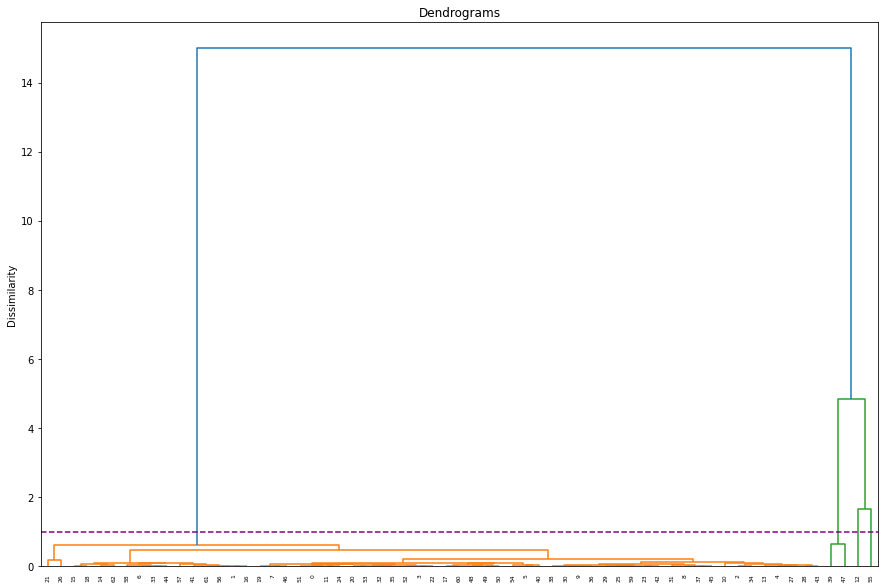

In [11]:
# Optimize Dissimilarity

# Plot
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
plt.ylabel('Dissimilarity')
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=1, color='purple', linestyle='--')

print('Suggested number of clusters: ', 5)

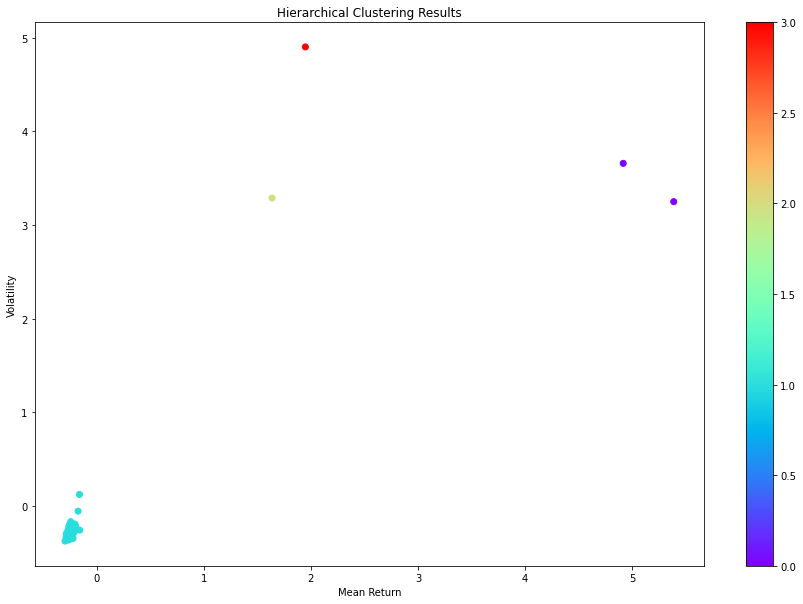

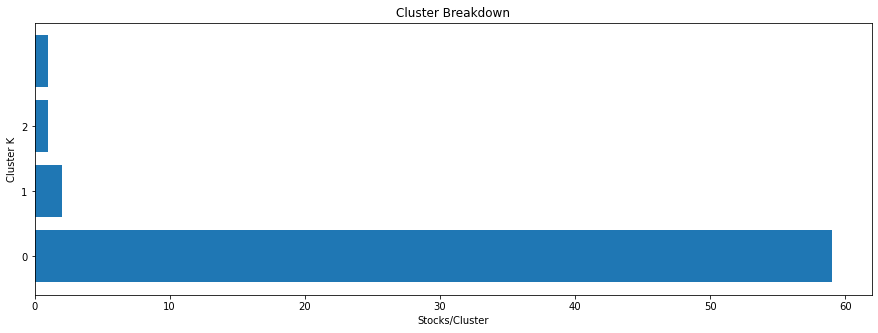

In [12]:
# Fit Model
clusters = 4
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='ward')
labels = hc.fit_predict(X)

# Plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Plot
clustered_series = pd.Series(index=X.index, data=hc.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=hc.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
fig = plt.figure(figsize= (15,5))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Breakdown')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster K')
y = [0,1,2]
plt.yticks(y)
plt.show()

### Affinity Propagation Clustering

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


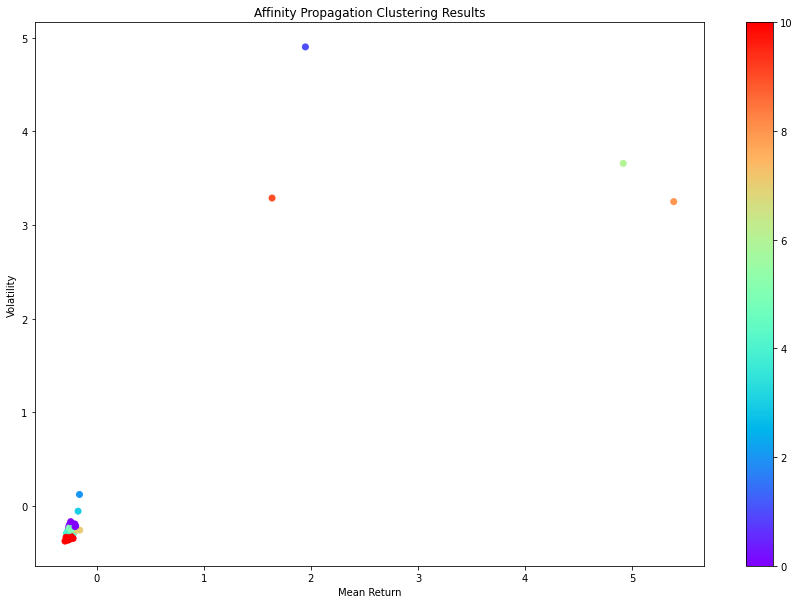

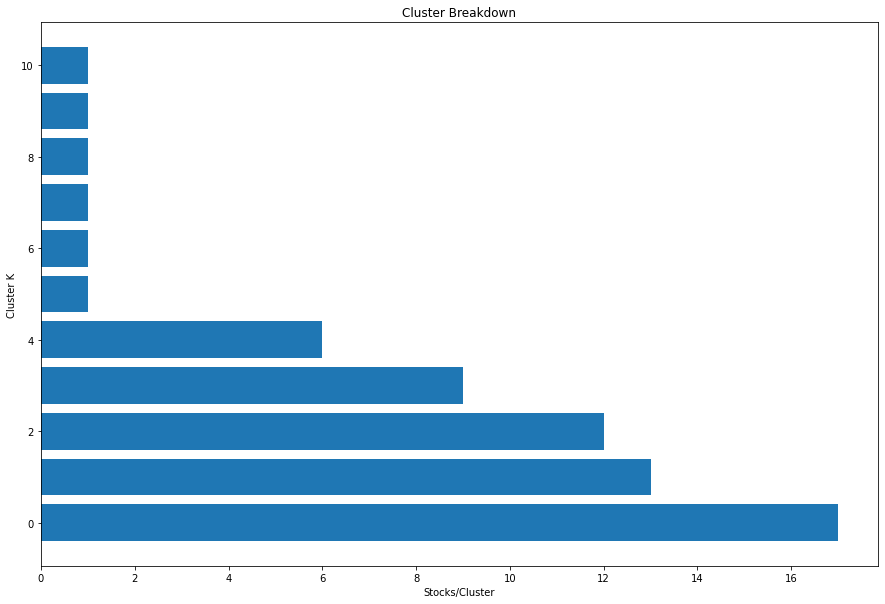

In [13]:
# Fit Model
ap = AffinityPropagation()
ap.fit(X)
labels = ap.predict(X)

# Plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Plot
clustered_series = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
fig = plt.figure(figsize= (15,10))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Breakdown')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster K')
plt.show()

The number of clusters is: 11


<Figure size 432x288 with 0 Axes>

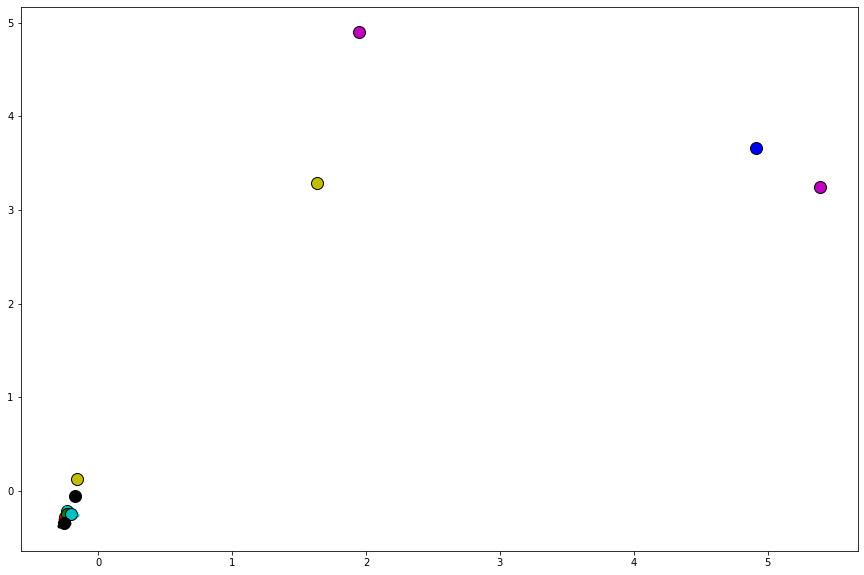

In [14]:
# Extract Cluster Centre
cci = ap.cluster_centers_indices_
labels = ap.labels_
clusters = len(cci)
print('The number of clusters is:',clusters)

# Plot
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
plt.show()

## Clustering Evaluation

In [15]:
print("K-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

K-Means Clustering 0.9431186161563241
Hierarchical Clustering 0.9431186161563241
Affinity Propagation Clustering 0.2974326177112519


## Selection Framework

In [16]:
# Clusters & Pairs Breakdown 
cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 5
Number of Pairs: 662


In [17]:
def find_coint_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [18]:
stockdata

,CRUDOIL,GOLDBLN,LCPCASH,EIAEBRT,OILBREN,WHEATSF,LAHCASH,LNICASH,CORNUS2,SILVERH,...,FUELOIL,NATBGAS,EEXPEAK,DAPNOCB,WSUGDLY,WOLAWCE,WSUGDLY.1,PAOLMAL,USTEERS,MILKGDA
110,0.039013,0.017571,0.051862,0.198772,0.070640,0.000000,0.020395,0.129296,0.013228,0.043557,...,0.044256,-0.056589,0.506681,0.000000,0.000000,0.012192,0.074171,0.046296,0.007300,0.000000
111,0.053302,-0.031116,-0.015471,0.067536,0.144588,0.000000,-0.014625,-0.027307,-0.005222,-0.088696,...,0.053368,0.039607,-0.083266,0.007692,0.000000,0.013887,0.001625,0.035398,0.004325,-0.023529
112,-0.004712,-0.005353,0.064444,0.066536,0.065301,0.053279,0.036609,0.031760,0.044619,0.069656,...,0.047943,0.065718,-0.055613,0.000000,0.000000,-0.001468,0.034063,0.008547,0.000000,0.000000
113,-0.122478,0.001478,-0.013794,-0.054408,-0.051786,-0.062257,-0.008272,-0.071749,-0.035176,0.000000,...,-0.081917,0.000146,0.428361,0.000000,0.000000,0.001750,-0.021961,0.000000,0.000000,0.000000
114,-0.021816,0.013050,-0.043925,-0.071166,-0.014044,-0.012448,-0.024543,-0.061492,-0.020833,-0.011597,...,0.020202,-0.037055,0.189397,0.000000,0.009772,-0.007894,0.000000,-0.033898,-0.009311,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.600575,0.000000,0.000000,0.000000,0.000000,0.000000,0.002172,0.000000
2452,0.031831,0.006451,0.000000,0.000000,0.000000,-0.006993,0.000000,0.000000,0.006211,0.007313,...,0.039121,-0.000037,-1.693773,0.000000,0.000000,0.000130,0.000000,0.000000,0.000000,-0.022556
2453,-0.005503,0.002784,0.016549,0.021978,0.023267,0.016432,0.027736,-0.001988,0.003086,0.009679,...,-0.003167,-0.030610,-4.648456,0.000000,0.000000,0.005959,0.019890,0.024793,0.000000,0.015385
2454,0.003353,0.006228,0.007151,0.011661,0.004066,0.000000,0.014609,0.020459,-0.006154,0.008987,...,0.010966,0.027541,-0.121665,0.000000,-0.002222,0.003413,0.004035,0.008065,0.000000,0.015152


In [19]:
# Pair Identification
cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_coint_pairs(stockdata[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print("Number of pairs:", len(pairs))
print("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
pairs

Number of pairs: 52
In those pairs, we found 57 unique tickers.


[('EIAEBRT', 'OILBREN'),
 ('EIAEBRT', 'LNICASH'),
 ('EIAEBRT', 'SILVERH'),
 ('EIAEBRT', 'EIAUSGJ'),
 ('EIAEBRT', 'BFO1MEU'),
 ('EIAEBRT', 'GOEUARA'),
 ('EIAEBRT', 'RHODNWE'),
 ('EIAEBRT', 'COTTONM'),
 ('EIAEBRT', 'EIALALS'),
 ('EIAEBRT', 'EIANYHO'),
 ('EIAEBRT', 'EIANYLS'),
 ('EIAEBRT', 'EIAGCLS'),
 ('EIAEBRT', 'SOYMKCT'),
 ('EIAEBRT', 'DIESELA'),
 ('EIAEBRT', 'FUELOIL'),
 ('EIAEBRT', 'WSUGDLY.1'),
 ('CRUDOIL', 'WHEATSF'),
 ('CRUDOIL', 'OILWTIN'),
 ('CRUDOIL', 'NAFCNWE'),
 ('CRUDOIL', 'COTSCIL'),
 ('CRUDOIL', 'CRUDWTC'),
 ('CRUDOIL', 'ETHANYH'),
 ('CRUDOIL', 'EIATXPR'),
 ('CRUDOIL', 'EIANYGR'),
 ('CRUDOIL', 'EIAGCGR'),
 ('CRUDOIL', 'OILWTXI'),
 ('CRUDOIL', 'NATBGAS'),
 ('CRUDOIL', 'PAOLMAL'),
 ('GOLDBLN', 'LAHCASH'),
 ('GOLDBLN', 'PLATFRE'),
 ('GOLDBLN', 'GOLDHAR'),
 ('GOLDBLN', 'LADCASH'),
 ('GOLDBLN', 'HOGNTMR'),
 ('GOLDBLN', 'LNACASH'),
 ('GOLDBLN', 'DAPNOCB'),
 ('GOLDBLN', 'WSUGDLY'),
 ('GOLDBLN', 'WOLAWCE'),
 ('GOLDBLN', 'USTEERS'),
 ('GOLDBLN', 'MILKGDA'),
 ('LCPCASH', 'CORNUS2')

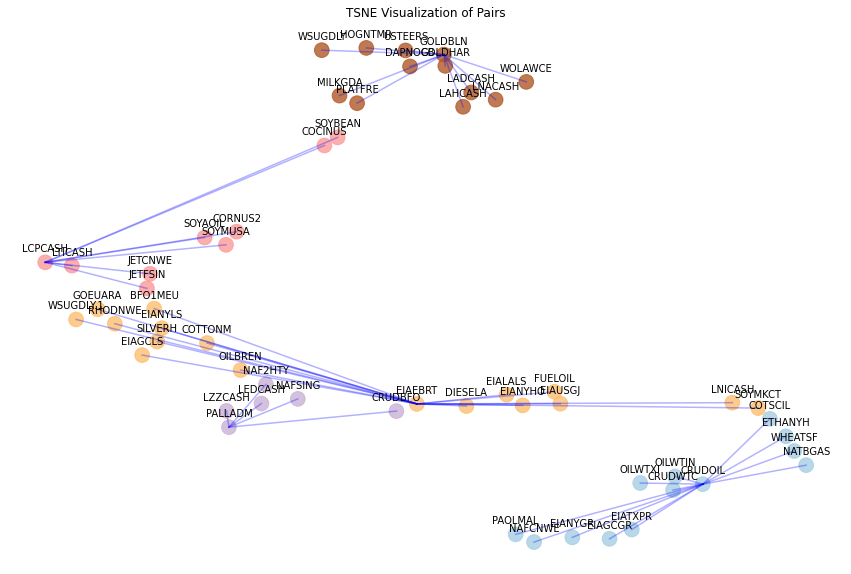

In [20]:
# TSNE Visualization
stocks = np.unique(pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]

X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

# Plot
plt.figure(1, facecolor='white',figsize=(15,10))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):
    label = name
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
plt.show()

In [21]:
pairs = pd.DataFrame(pairs)
pairs.to_excel("clustering_pairs.xlsx")

# <u> Part 2: Structural Break Identification

In [22]:
# set theme
import seaborn as sns

plt.style.use('seaborn')
sns.set_style('darkgrid')

In [23]:
# Data import, slicing and transformation

raw_data = pd.read_excel('commod_data.xlsx', sheet_name = 'Sheet1', index_col='Date')

raw_data_returns = np.log(raw_data).diff().dropna()

raw_data_prices = raw_data.dropna(axis=1)
raw_data_prices

,CRUDOIL,GOLDBLN,LCPCASH,EIAEBRT,OILBREN,WHEATSF,LAHCASH,LNICASH,CORNUS2,SILVERH,...,FUELOIL,NATBGAS,EEXPEAK,DAPNOCB,WSUGDLY,WOLAWCE,WSUGDLY.1,PAOLMAL,USTEERS,MILKGDA
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-01,123.26,914.40,8073.0,124.16,123.98,5.83,2884.45,18172.0,5.15,17.57,...,3.4143,1.156113,126.982151,1195.60,831,804.64320,0.1489,1100.0,96.92,1.4400
2008-08-04,121.41,906.20,7734.0,121.87,121.63,5.53,2831.00,17887.0,4.85,17.09,...,3.3251,1.115142,108.001374,1192.80,831,805.80960,0.1423,1050.0,96.94,1.4400
2008-08-05,119.17,880.40,7768.0,116.50,116.88,5.92,2849.50,17474.0,4.75,16.68,...,3.2595,1.085193,110.651676,1192.80,831,792.33120,0.1476,1000.0,96.94,1.4400
2008-08-06,118.58,878.40,7767.0,114.47,114.62,5.83,2855.75,17678.0,4.60,16.50,...,3.2155,1.078347,122.037714,1192.80,831,785.76480,0.1499,1000.0,97.00,1.4400
2008-08-07,120.02,872.85,7810.0,116.94,117.00,6.21,2868.25,18749.0,4.72,16.26,...,3.2115,1.060588,109.358182,1192.80,831,767.87190,0.1456,1015.0,97.59,1.4400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,99.49,1898.40,9783.8,99.27,102.22,10.71,3073.50,32607.0,7.79,23.60,...,4.2167,1.950124,241.391126,1047.20,473,976.78985,0.1894,1990.0,143.02,1.7550
2022-04-26,101.70,1905.32,9863.5,102.89,105.08,10.92,3048.60,33055.0,7.79,23.54,...,4.5100,2.064209,254.079155,1047.20,473,977.88345,0.1898,1940.0,143.02,1.7075
2022-04-27,102.02,1885.36,9866.5,103.30,105.33,10.90,3080.70,33281.0,7.92,23.37,...,4.8035,1.871173,232.751367,1047.20,473,972.87985,0.1897,1940.0,143.02,1.7275


In [24]:
# Dataframe for unique pairs

unique_pairs = pd.read_excel('final_pairs.xlsx', sheet_name='Sheet1')
selected_pairs = unique_pairs["Concat"].tolist()
print(selected_pairs)

['EIAEBRT-OILBREN', 'EIAEBRT-EIAUSGJ', 'EIAEBRT-BFO1MEU', 'EIAEBRT-GOEUARA', 'EIAEBRT-EIALALS', 'EIAEBRT-EIANYHO', 'EIAEBRT-EIANYLS', 'EIAEBRT-EIAGCLS', 'EIAEBRT-DIESELA', 'EIAEBRT-FUELOIL', 'CRUDOIL-OILWTIN', 'CRUDOIL-NAFCNWE', 'CRUDOIL-CRUDWTC', 'CRUDOIL-ETHANYH', 'CRUDOIL-EIANYGR', 'CRUDOIL-EIAGCGR', 'CRUDOIL-OILWTXI', 'GOLDBLN-GOLDHAR', 'LCPCASH-JETCNWE', 'LCPCASH-LTICASH', 'PALLADM-LZZCASH', 'LNICASH-RHODNWE', 'LCPCASH-GOEUARA', 'WHEATSF-NAFCNWE', 'WHEATSF-EIANYGR', 'WHEATSF-EIAGCGR', 'WHEATSF-NATBGAS']


## Parsing Function

In [25]:
# Function to parse concatenated pairs 
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

## Visualization of the structural break process using 'EIAEBRT-BFO1MEU' as example

<AxesSubplot:xlabel='Date'>

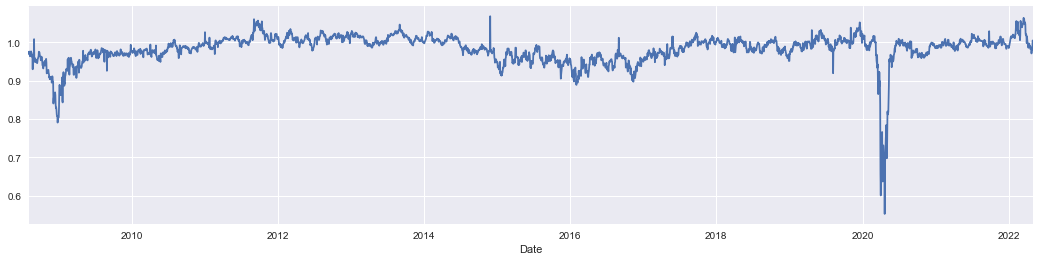

In [26]:
# step 1: we first identify the spread ratio

pair = 'EIAEBRT-BFO1MEU'
s1,s2 = parse_pair(pair)
spread = raw_data_prices[s1]/raw_data_prices[s2]

spread.plot(figsize=(18,4))

In [27]:
# step 2: we fit the model with the given conditions

import statsmodels.api as sm

mod = sm.tsa.MarkovRegression(spread, k_regimes=2, switching_variance=True)
res = mod.fit(search_reps=100)

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


In [28]:
print(res.summary())

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                 3586
Model:               MarkovRegression   Log Likelihood                8465.914
Date:                Sat, 28 May 2022   AIC                         -16919.828
Time:                        21:35:12   BIC                         -16882.720
Sample:                    08-01-2008   HQIC                        -16906.601
                         - 04-29-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0012      0.000   2949.876      0.000       1.001       1.002
sigma2         0.0002   6.65e-06     23.651      0.0

In [29]:
# Need to research more on the expected durations. Could be used to set the dates for high and low regime periods.

res.expected_durations

array([134.14687873,  96.03954744])

Text(0.5, 1.0, 'Probability of high-mean regime')

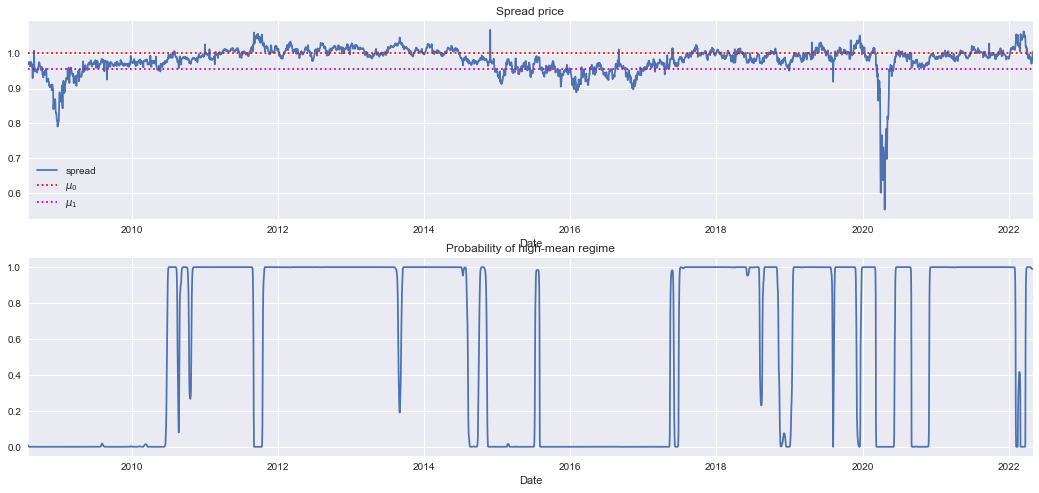

In [30]:
# step 3: we plot the graphs to vizualise the  

fig, axs = plt.subplots(2,1,figsize=(18,8))
spread.plot(ax=axs[0], label='spread')
axs[0].axhline(y=res.params['const[0]'], label=r'$\mu_0$', linestyle='dotted', c='r')
axs[0].axhline(y=res.params['const[1]'], label=r'$\mu_1$', linestyle='dotted', c='m')
axs[0].set_title('Spread price')
axs[0].legend()
res.smoothed_marginal_probabilities[0].plot(ax=axs[1])
axs[1].set_title('Probability of high-mean regime')

## Now, we just run a loop to get the dates of the structural breaks for all pairs for both train and test set

In [31]:
# Function stuctural breaks

def structural_break(pair):
    s1,s2 = parse_pair(pair)
    spread = raw_data_prices[s1]/raw_data_prices[s2]
    
    mod = sm.tsa.MarkovRegression(spread, k_regimes=2,switching_variance=True)
    res = mod.fit(search_reps=100)
    
    regime = pd.DataFrame(res.smoothed_marginal_probabilities)
    regime['Signal'] = regime[0].apply(lambda x: round(x))
    regime['Position'] = regime['Signal'].diff()
    
    dates = []
    for i in range(len(regime)):
        if regime['Position'][i] != 0:
            dates.append(regime.index[i])
    
    break_dates = pd.Series(dates, name=pair)
    
    return break_dates

In [32]:
# Running the function across all the pairs and merging them into one dataframe

struc_break_dates = pd.DataFrame()
#result_train = pd.DataFrame(structural_break_train('EIAEBRT-BFO1MEU'))

for pair in selected_pairs:
  try:
    struc_break_dates = pd.concat([struc_break_dates, structural_break(pair)], axis=1)
  
  except:
    continue

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/regime_switching/markov_regression.py:188: RuntimeWarning: divide by zero encountered in true_divide
  -0.5 * resid**2 / variance - 0.5 * np.log(2 * np.pi * variance))
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/regime_switching/markov_regression.py:188: RuntimeWarning: invalid value encountered in true_divide
  -0.5 * resid**2 / variance - 0.5 * np.log(2 * np.pi * variance))
/Users/peterchettiar/opt/an

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/regime_switching/markov_regression.py:188: RuntimeWarning: divide by zero encountered in true_divide
  -0.5 * resid**2 / variance - 0.5 * np.log(2 * np.pi * variance))
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/regime_switching/markov_regression.py:188: RuntimeWarning: invalid value encountered in true_divide
  -0.5 * resid**2 / variance - 0.5 * np.log(2 * np.pi * variance))
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/regime_switching/markov_regression.py:188: RuntimeWarning: divide by zero encountered in log
  -0.5 * resid**2 / variance - 0.5 * np.log(2 * np.pi * variance))
/Users/peterchettiar/opt/ana

/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/peterchettiar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


In [33]:
struc_break_dates

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS
0,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01
1,2008-09-01,2010-06-28,2009-02-27,2020-03-31,2009-01-12,2008-11-07,2015-12-09,2008-10-23,2010-04-29,2008-10-27,2008-10-21,2008-11-06,2008-08-27,2008-08-26,2008-08-29
2,2008-09-02,2010-08-19,2009-03-19,2020-04-01,2009-01-23,2009-06-05,2016-04-29,2009-03-13,2018-10-31,2018-07-12,2008-11-18,2009-03-23,2008-09-22,2008-10-08,2008-12-19
3,2008-10-15,2010-08-27,2009-04-06,2020-04-21,2009-01-27,2009-07-03,2016-11-08,2009-05-07,NaT,NaT,2009-03-02,2014-12-04,2008-11-11,2008-11-11,2009-03-05
4,2008-10-16,2010-10-15,2011-11-10,2020-04-22,2009-02-05,2009-07-14,2016-12-06,2009-06-24,NaT,NaT,2009-03-20,2015-02-11,2009-05-13,2009-05-14,2009-08-06
5,2008-11-27,2010-10-26,2011-11-30,NaT,2009-08-04,2009-11-12,2017-05-31,2010-09-15,NaT,NaT,2009-03-31,2015-06-30,2009-08-06,2009-08-06,2010-08-04
6,2009-02-05,2011-09-02,2012-06-12,NaT,2009-09-15,2009-12-28,2017-11-01,2010-11-18,NaT,NaT,2009-06-02,2015-07-20,2009-11-16,2009-11-16,2010-09-24
7,2009-02-12,2011-10-19,2012-07-13,NaT,2009-11-17,2010-09-10,2020-02-27,2011-01-25,NaT,NaT,2009-07-02,2015-08-06,2010-03-16,2010-03-08,2011-01-25
8,2009-02-23,2013-08-27,2012-09-19,NaT,2010-03-31,2010-09-29,2022-01-28,2011-06-02,NaT,NaT,2011-09-14,2015-09-01,2010-05-04,2010-05-04,2011-02-21
9,2011-09-02,2013-09-09,2012-11-01,NaT,2010-04-13,2010-10-12,NaT,2011-10-04,NaT,NaT,2014-11-11,2015-12-09,2010-08-04,2010-08-04,2012-07-11


In [34]:
struc_break_dates.to_csv("Sructural_Breaks.csv")